In [13]:
from torch.utils.data import DataLoader
import torchvision
from model import CNN,ResNet,VGG,Alexnet
import torch
from get_data import carHacking_Data
from torch import nn
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
class Args:
    def __init__(self):
        self.B = 200
        self.root = '/home/raoxy/data/carhacking_dirichlet_05/'
        self.optimizer = "adam"
        self.lr = 0.05
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.weight_decay = 0.0001
        self.E = 10
        self.gamma = 0.1
        self.step_size = 100
args = Args()

# m,_ = VGG()
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preVGGbest.pth')
# m.load_state_dict(state_dict)

# m,_ = Alexnet()
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preAlexNetbest.pth')
# m.load_state_dict(state_dict)

def get_fpr(m):
    m.name = "car_12"
    use_cuda = torch.cuda.is_available()
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    Val  = DataLoader(
            torchvision.datasets.ImageFolder(root=args.root+m.name+"/train",
                                             transform=torchvision.transforms.ToTensor()),
            batch_size=args.B,
            shuffle=True, **kwargs)

    def get_val_loss(args, model, Val):
        model.eval()
        y_true = []
        y_scores = []
        for (seq, label) in Val:
            with torch.no_grad():
                seq = seq
                labels = label.long().squeeze()
                outputs = model(seq)
                probabilities = torch.sigmoid(outputs).numpy()
                y_scores.extend(probabilities)
                y_true.extend(labels.numpy())
        return y_true,y_scores
    true_label,predict_score = get_val_loss(args, m, Val)
    
    label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
    n_classes = len(label_names)
    binarize_predict = label_binarize(true_label, classes=[i for i in range(n_classes)])
    # 计算FPR（假正率）和TPR（真正率）
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = metrics.roc_curve(binarize_predict[:,i], [socre_i[i] for socre_i in predict_score])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("roc_auc = ",roc_auc)
    return fpr,tpr,roc_auc


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
n_classes = len(label_names)
# 创建一个大图和四个子图
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

lw=2
# 绘制第一个模型的ROC曲线
m= CNN(num_class=5,name="car_12")
state_dict = torch.load('CNN/pth/CNN.pth')
m.load_state_dict(state_dict)
fpr,tpr,roc_auc = get_fpr(m)
for i in range(n_classes):
    axs[0, 0].plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
# .plot(fpr, tpr, label='模型1 (AUC = %0.2f)' % roc_auc1)
axs[0, 0].plot([0, 1], [0, 1], 'k--')
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('CNN ROC Curve')
axs[0, 0].legend(loc="lower right")
axs[0, 0].grid()

# 绘制第二个模型的ROC曲线
m2,_ = ResNet()
state_dict = torch.load('ResNet/pth/ResNet.pth')
m2.load_state_dict(state_dict)
fpr2,tpr2,roc_auc2 = get_fpr(m2)
# axs[0, 1].plot(fpr2, tpr2, label='模型2 (AUC = %0.2f)' % roc_auc2)
for i in range(n_classes):
    axs[0, 1].plot(fpr2[i], tpr2[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc2[i]))
axs[0, 1].plot([0, 1], [0, 1], 'k--')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_title('ResNet ROC Curve')
axs[0, 1].legend(loc="lower right")
axs[0, 1].grid()

# 绘制第三个模型的ROC曲线
m3,_ = VGG()
state_dict = torch.load('ResNet/pth/VGG.pth')
m3.load_state_dict(state_dict)
fpr3,tpr3,roc_auc3 = get_fpr(m3)
# axs[1, 0].plot(fpr3, tpr3, label='模型3 (AUC = %0.2f)' % roc_auc3)
for i in range(n_classes):
    axs[1, 0].plot(fpr3[i], tpr3[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc3[i]))
axs[1, 0].plot([0, 1], [0, 1], 'k--')
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].set_title('VGG ROC Curve')
axs[1, 0].legend(loc="lower right")
axs[1, 0].grid()
# 绘制第四个模型的ROC曲线
# axs[1, 1].plot(fpr4, tpr4, label='模型4 (AUC = %0.2f)' % roc_auc4)
for i in range(n_classes):
    axs[1, 1].plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
axs[1, 1].plot([0, 1], [0, 1], 'k--')
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_title('AlexNet ROC Curve')
axs[1, 1].legend(loc="lower right")
axs[1, 1].grid()
# 显示图形
plt.tight_layout()
plt.show()

In [ ]:

# 绘制第一个模型的ROC曲线
m= CNN(num_class=5,name="car_12")
state_dict = torch.load('CNN/pth/CNN.pth')
m.load_state_dict(state_dict)
fpr,tpr,roc_auc = get_fpr(m)

m2,_ = ResNet()
state_dict = torch.load('ResNet/pth/ResNet.pth')
m2.load_state_dict(state_dict)
fpr2,tpr2,roc_auc2 = get_fpr(m2)

m3,_ = VGG()
state_dict = torch.load('VGG/pth/VGG.pth')
m3.load_state_dict(state_dict)
fpr3,tpr3,roc_auc3 = get_fpr(m3)

m4,_ = Alexnet()
state_dict = torch.load('AlexNet/pth/AlexNet.pth')
m4.load_state_dict(state_dict)
fpr4,tpr4,roc_auc4 = get_fpr(m4)

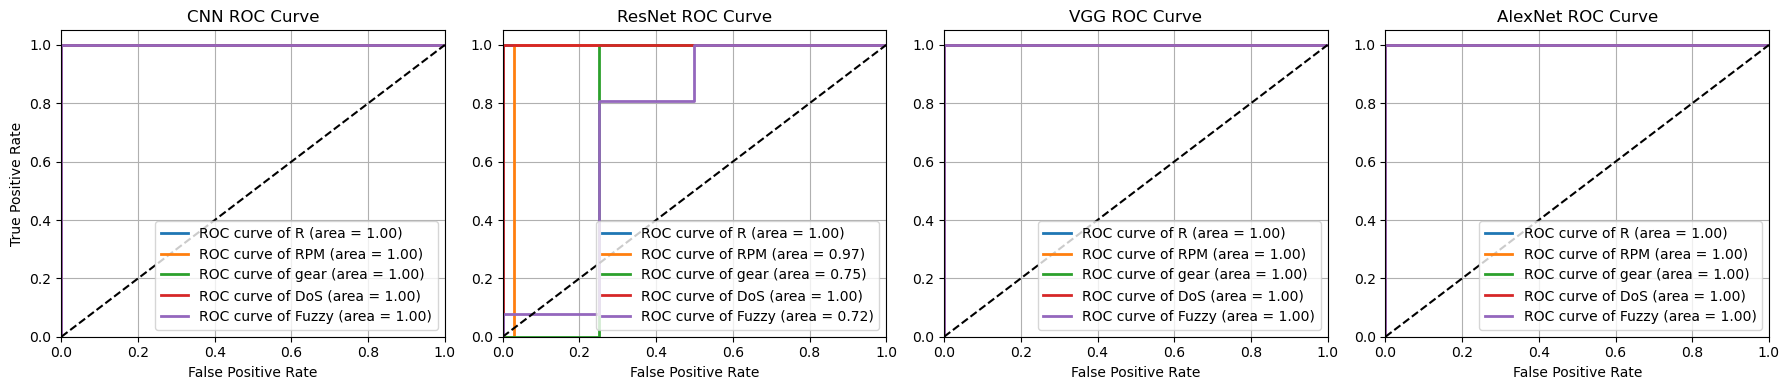

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
n_classes = len(label_names)
# 创建一个大图和四个子图
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

lw=2
for i in range(n_classes):
    axs[0].plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
# .plot(fpr, tpr, label='模型1 (AUC = %0.2f)' % roc_auc1)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('CNN ROC Curve')
axs[0].legend(loc="lower right")
axs[0].grid()

# 绘制第二个模型的ROC曲线
# axs[1].plot(fpr2, tpr2, label='模型2 (AUC = %0.2f)' % roc_auc2)
for i in range(n_classes):
    axs[1].plot(fpr2[i], tpr2[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc2[i]))
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
# axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ResNet ROC Curve')
axs[1].legend(loc="lower right")
axs[1].grid()

# 绘制第三个模型的ROC曲线
# axs[2].plot(fpr3, tpr3, label='模型3 (AUC = %0.2f)' % roc_auc3)
for i in range(n_classes):
    axs[2].plot(fpr3[i], tpr3[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc3[i]))
axs[2].plot([0, 1], [0, 1], 'k--')
axs[2].set_xlim([0.0, 1.0])
axs[2].set_ylim([0.0, 1.05])
axs[2].set_xlabel('False Positive Rate')
# axs[2].set_ylabel('True Positive Rate')
axs[2].set_title('VGG ROC Curve')
axs[2].legend(loc="lower right")
axs[2].grid()

# 绘制第四个模型的ROC曲线

# axs[3].plot(fpr4, tpr4, label='模型4 (AUC = %0.2f)' % roc_auc4)
for i in range(n_classes):
    axs[3].plot(fpr4[i], tpr4[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc4[i]))
axs[3].plot([0, 1], [0, 1], 'k--')
axs[3].set_xlim([0.0, 1.0])
axs[3].set_ylim([0.0, 1.05])
axs[3].set_xlabel('False Positive Rate')
# axs[3].set_ylabel('True Positive Rate')
axs[3].set_title('AlexNet ROC Curve')
axs[3].legend(loc="lower right")
axs[3].grid()

# 显示图形
plt.tight_layout()
plt.show()